\newpage

# Calibration of the HBV model

In this chapter the parameters used in the HBV model are calibrated using the observation data. A set of parameters is used by the HBV model to model the discharge. These parameters are calibrated to make the model work for the catchment area of the Wien River. 

## Model Selection

To be able to model the expected future discharge, the Hydrologiska Byråns Vattenbalansavdelning (HBV) model is chosen. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model represents a catchment area by using interconnected storage reservoirs to simulate the movement of water. By adjusting nine parameters, the HBV model can be calibrated to different catchment areas. The model requires 3 inputs, the forcings, which are precipitation, temperature and potential evapotranspiration.

The nine parameters that have to be calibrated are Imax, Ce, Sumax, Beta, Pmax, Tlag, Kf, Ks, and FM. The parameters represent the following:

- **Imax**: Maximum intensity
- **Ce**: Coefficient of evaporation
- **Sumax**: Field capacity (FC in figure 5)
- **Beta**: Shapecoefficient
- **Pmax**: Maximum percolation rate (PERC in figure 5)
- **Tlag**: Time lag (MAXBAS in figure 5)
- **Kf**: Fast run-off parameter (K0 in figure 5)
- **Ks**: Slow run-off parameter (K1 in figure 5)
- **FM**: Degree-day factor (CFMAX in figure 5)\
(Wawrzyniak et al., 2017; Seibert, 2000)


A visual representation of the HBV model can be seen in the figure below.

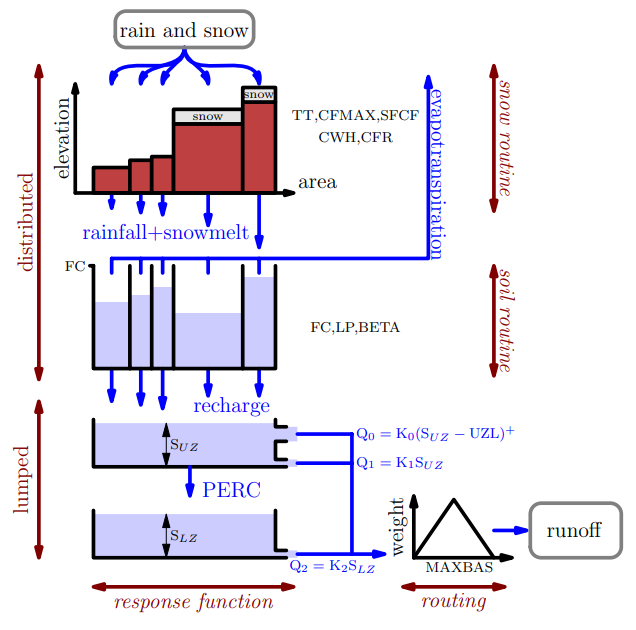\
Figure 5: Layout HBV Model (Driessen et al., 2010)

## Calibration

The model's performance with a certain parameter combination is assesed by evaluating how well it represents the distribution of discharges, since for my research the exact timing of certain discharges and peaks is not relevant. To measure the difference between the observed and modelled discharges, the root mean squared error (RMSE) is used. The Nelder-Mead optimization is then applied to find the best set of parameters that results in the lowest RMSE. The model is trained on the first 75 percent of the observation data, and is then tested on the last 25 percent of the data. The test shows how well the model performs on data it has never seen before. 

### Root Mean Squared Error

The Root Mean Squared Error (RMSE) is used to calculate the average overall difference between the observed and modelled discharge. First, the difference between the observed and modelled discharge is calculated for each day, called the error. The RMSE squares this error to give more weight to large differences, such as when observed peaks are not modelled well. This method causes peaks to contribute more heavily to the RMSE. After this, the mean of all squared values is taken, before the square root is applied to get the RMSE.

### Nelder Mead Optimization 

The optimal parameter combination that results in the lowest RMSE is calculated using Nelder-Mead Optimization. The Nelder-Mead algorithm is a way to find the minimum of a function without needing to calculate its derivative. It does this by adjusting a group of points through steps like reflecting, expanding, squeezing, or shrinking until it gets closer to the best solution (Chen, 2023).

### Calibration Results

In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import minimize

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

In [3]:
# calibration dates on 75% of experiment dates

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

# print(camelsgb_forcing)

In [6]:
# Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). 
# For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below.

#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
# ds_forcing["Q"].plot()
# print(ds_forcing["time"].values)

In [7]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
# p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


In [8]:
def objective_function_sorted_maximum(model_output, observation, calibration_start_time, calibration_end_time):
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    model_output.index = model_output.index.tz_localize(None)  # Remove timezone
    observation.index = observation.index.tz_localize(None)
    calibration_start_time = calibration_start_time.tz_localize(None)
    calibration_end_time = calibration_end_time.tz_localize(None)

    # print(model_output.index)
    # print(observation.index)

    
    model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
    obs_filtered = observation.loc[calibration_start_time:calibration_end_time]
    # obs_filtered = observation.loc[(calibration_start_time + pd.Timedelta(days=1)) : calibration_end_time]

    
    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(obs_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    # sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0]
    # sorted_obs_data_subset = sorted_obs_data[return_periods_years_obs >= 0]
    sorted_model_data_subset = sorted_model_data
    sorted_obs_data_subset = sorted_obs_data

    
    if len(sorted_model_data_subset) != len(sorted_obs_data_subset):
        print(len(sorted_model_data_subset), len(sorted_obs_data_subset))
        raise ValueError("observation and data not equal length")

    objective_this_model = np.sqrt(np.mean((sorted_model_data_subset - sorted_obs_data_subset)**2))

    return objective_this_model

In [9]:
# Q_pandas = ds_forcing["Q"].to_dataframe()

# def optimization_function(parameter_vector):
#     model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
#     config_file, _ = model.setup(            parameters = parameter_vector,
#                             initial_storage=s_0,
#                             cfg_dir = "configFiles/hbv_ensembleMember_",
#                                )
#     model.initialize(config_file)


#    # discharge_this_timestep = model.get_value("Q") 
#     Q_m = []
#     time = []
#     while model.time < model.end_time:
#         model.update()
#         discharge_this_timestep = model.get_value("Q")
#         Q_m.append(discharge_this_timestep[0])
#         time.append(pd.Timestamp(model.time_as_datetime.date()))
#    # model.finalize()
#    # print(model.get_value("Q"))

#     #calculate the objective function 
#     discharge_dataframe = pd.DataFrame({'Modelled_discharge': Q_m}, index=pd.to_datetime(time))
#     objective_this_model = objective_function_sorted_maximum(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
#     del Q_m, time, discharge_dataframe
   
#     if np.isnan(objective_this_model):
#         return np.inf
    
#     return objective_this_model

In [10]:
######## NEW

Q_pandas = ds_forcing["Q"].to_dataframe()
# obs_all_dataframe = ds_forcing.to_dataframe() 
# obs_series = obs_all_dataframe["Q"]

def optimization_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))
    
    #calculate the objective function 
    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)
   # print(len(discharge_series), len(Q_m), len(time), len(obs_series))
    objective_this_model = objective_function_sorted_maximum(discharge_series,Q_pandas,calibration_start_time + pd.Timedelta(days=1),calibration_end_time)
    del Q_m, time, discharge_series
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [11]:
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# result = minimize(optimization_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000})

In [12]:
# result

In [13]:
# result.x
# 90/10
# # result = [6.51669781e-05, 6.38655600e-01, 5.30024294e+01, 1.56641841e+00,
# #        1.10734080e+00, 1.49999999e+00, 5.50209588e-01, 3.74966606e-02,
# #        1.04773070e+00]

# 70/30
# result = [5.15724216e-05, 8.36587345e-01, 3.90778393e+01, 3.57466531e+00,
#        1.06383450e+00, 9.37562028e-01, 3.02412699e-01, 8.15566365e-02,
#        2.90551458e+00]

# result = [4.00431542e-07, 1.18207742e+00, 6.18107025e+01, 3.43810639e+00,
#        1.46429514e+00, 1.50000000e+00, 6.12583301e-01, 2.73318870e-03,
#        7.95615325e-01]


result = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

The parameter combination that resulted in the best perfoming modelled discharge is as follows: \
Imax = 0.00\
Ce = 1.324\
Sumax = 100.048\
Beta = 3.894\
Pmax = 0.666\
Tlag = 0.043\
Kf = 1.005\
Ks = 1.94\
FM = 0.459

In [14]:
# result.fun
# 90/10
# # objective = 0.027397519552779696

# 70/30
# objective = 0.01965939310646257



In [15]:
par = result
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par, initial_storage=s_0)
model.initialize(config_file)


In [16]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [17]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [18]:
df = pd.DataFrame(model_output)

calibration_start_time = pd.to_datetime(calibration_start_time)
calibration_end_time = pd.to_datetime(calibration_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
calibration_start_time = calibration_start_time.tz_localize(None)
calibration_end_time = calibration_end_time.tz_localize(None)

model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
ds_forcing_filtered = ds_forcing["Q"].loc[calibration_start_time:calibration_end_time]

The observed and modelled discharges and their distributions for the calibration period can be seen below in figures 6 and 7.

In [19]:
# plt.figure(figsize=(4, 3))
# ds_forcing_filtered.plot(label="Observed discharge")
# model_output_filtered.plot()
# plt.legend()
# plt.ylabel("Discharge (mm/d)")
# plt.title('Observed and Modelled discharge calibration period')
# plt.text(0.5, -0.5, "Figure 6: Modelled and observed discharge calibration period", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes)
# plt.show();

In [20]:
# # Sort data from high to low
# sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
# ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

# #calculate return periods
# m = len(sorted_model_data)
# rank = np.arange(1, m + 1)
# return_periods_days_model = (m + 1) / rank
# return_periods_years_model = return_periods_days_model / 365.25

# m = len(ds_forcing_filtered)
# rank = np.arange(1, m + 1)
# return_periods_days_obs = (m + 1) / rank
# return_periods_years_obs = return_periods_days_obs / 365.25

# plt.figure(figsize=(4, 3))
# plt.xscale('log')
# plt.scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
# plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations', marker='.')
# plt.legend()
# plt.xlabel('Return period (years)')
# plt.ylabel('Discharge (mm/day)')
# plt.title('Observed and Modelled discharge distribution calibration period')
# plt.text(0.5, -0.3, "Figure 7: Modelled and observed discharge distribution calibration period", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);

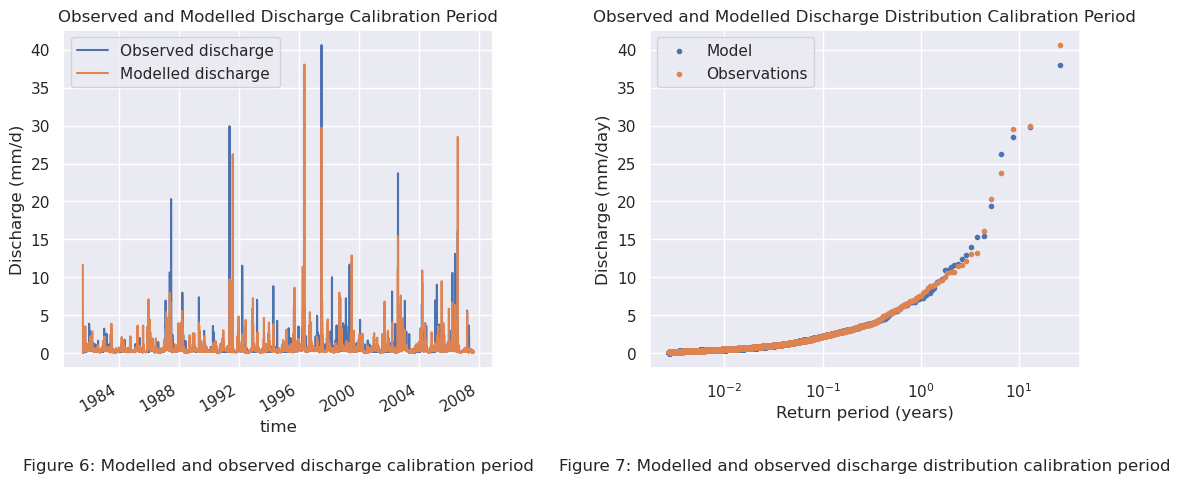

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Twee subplots naast elkaar

# Eerste subplot: Observed vs. Modelled discharge
ds_forcing_filtered.plot(ax=axes[0], label="Observed discharge")
model_output_filtered.plot(ax=axes[0], label="Modelled discharge")
axes[0].legend()
axes[0].set_ylabel("Discharge (mm/d)")
axes[0].set_title("Observed and Modelled Discharge Calibration Period")
axes[0].text(0.5, -0.3, "Figure 6: Modelled and observed discharge calibration period", 
             ha="center", fontsize=12, transform=axes[0].transAxes)

# Tweede subplot: Return period plot
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
sorted_ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

m_model = len(sorted_model_data)
rank_model = np.arange(1, m_model + 1)
return_periods_years_model = (m_model + 1) / rank_model / 365.25

m_obs = len(sorted_ds_forcing_filtered)
rank_obs = np.arange(1, m_obs + 1)
return_periods_years_obs = (m_obs + 1) / rank_obs / 365.25

axes[1].set_xscale('log')
axes[1].scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
axes[1].scatter(return_periods_years_obs, sorted_ds_forcing_filtered, label='Observations', marker='.')
axes[1].legend()
axes[1].set_xlabel('Return period (years)')
axes[1].set_ylabel('Discharge (mm/day)')
axes[1].set_title('Observed and Modelled Discharge Distribution Calibration Period')
axes[1].text(0.5, -0.3, "Figure 7: Modelled and observed discharge distribution calibration period", 
             ha="center", fontsize=12, transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

In [22]:
validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

df.index = df.index.tz_localize(None)  # Remove timezone
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)
# Filter de modeloutput voor de geselecteerde periode
model_output_filtered = model_output.loc[validation_start_time:validation_end_time]

# Als je ook de waargenomen afvoer wilt filteren, doe je hetzelfde:
ds_forcing_filtered = ds_forcing["Q"].loc[validation_start_time:validation_end_time]

To test the ability of the model to predict discharges for periods of which it has never seen data before, the modelled discharge for the validation period is compared to the observed discharge. This can be seen in figure 8. In figure 9 the distributions of the modelled and observed discharges in the validation period can be seen. 

In [23]:
# plt.figure(figsize=(4, 3))
# ds_forcing_filtered.plot(label="Observed discharge")
# model_output_filtered.plot()
# plt.legend()
# plt.ylabel("Discharge (mm/d)")
# plt.title('Observed and Modelled discharge validation period')
# plt.text(0.5, -0.4, "Figure 8: Modelled and observed discharge validation period", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);

In [24]:
# # Sort data from high to low
# sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
# ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

# #calculate return periods
# m = len(sorted_model_data)
# rank = np.arange(1, m + 1)
# return_periods_days_model = (m + 1) / rank
# return_periods_years_model = return_periods_days_model / 365.25


# m = len(ds_forcing_filtered)
# rank = np.arange(1, m + 1)
# return_periods_days_obs = (m + 1) / rank
# return_periods_years_obs = return_periods_days_obs / 365.25
# plt.figure(figsize=(4, 3))
# plt.xscale('log')
# plt.scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
# plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations', marker='.')
# plt.legend()
# plt.xlabel('Return period (years)')
# plt.ylabel('Discharge (mm/day)')
# plt.title('Observed and Modelled discharge distribution validation period')
# plt.text(0.5, -0.3, "Figure 9: Modelled and observed discharge distribution validation period", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);

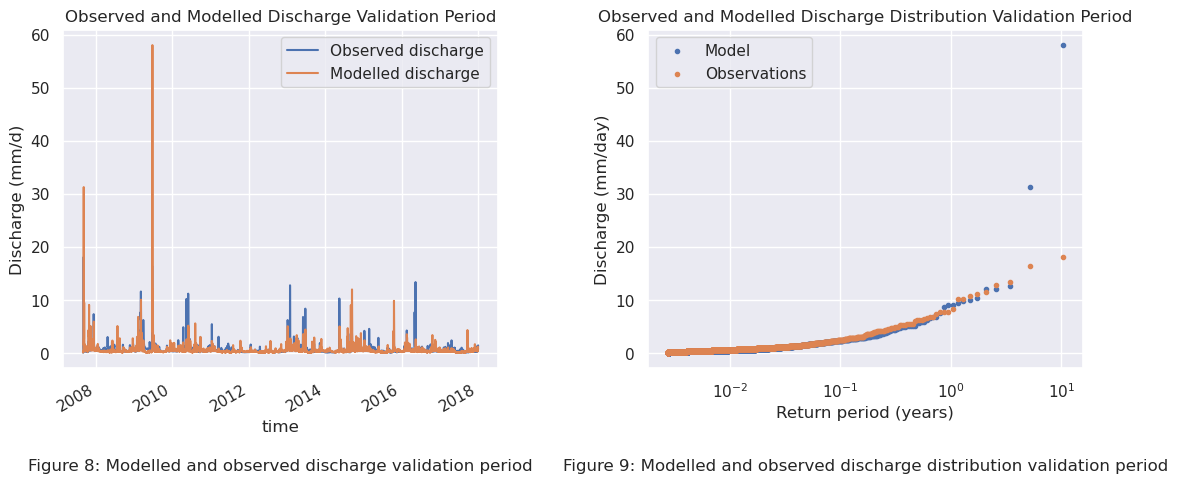

In [25]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Twee subplots naast elkaar

# Eerste subplot: Observed vs. Modelled discharge
ds_forcing_filtered.plot(ax=axes[0], label="Observed discharge")
model_output_filtered.plot(ax=axes[0], label="Modelled discharge")
axes[0].legend()
axes[0].set_ylabel("Discharge (mm/d)")
axes[0].set_title("Observed and Modelled Discharge Validation Period")
axes[0].text(0.5, -0.3, "Figure 8: Modelled and observed discharge validation period", 
             ha="center", fontsize=12, transform=axes[0].transAxes)

# Tweede subplot: Return period plot
sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
sorted_ds_forcing_filtered = np.sort(ds_forcing_filtered)[::-1]

m_model = len(sorted_model_data)
rank_model = np.arange(1, m_model + 1)
return_periods_years_model = (m_model + 1) / rank_model / 365.25

m_obs = len(sorted_ds_forcing_filtered)
rank_obs = np.arange(1, m_obs + 1)
return_periods_years_obs = (m_obs + 1) / rank_obs / 365.25

axes[1].set_xscale('log')
axes[1].scatter(return_periods_years_model, sorted_model_data, label='Model', marker='.')
axes[1].scatter(return_periods_years_obs, sorted_ds_forcing_filtered, label='Observations', marker='.')
axes[1].legend()
axes[1].set_xlabel('Return period (years)')
axes[1].set_ylabel('Discharge (mm/day)')
axes[1].set_title('Observed and Modelled Discharge Distribution Validation Period')
axes[1].text(0.5, -0.3, "Figure 9: Modelled and observed discharge distribution validation period", 
             ha="center", fontsize=12, transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

The RMSE for both the calibration and validation period can be calculated and compared. The RMSE of the calibarion period is 0.0632, and is 0.7020 for the validation period. The RMSE of the validation period is around 11 times larger than the one for the calibration period. The cause of the RMSE being larger for the validation period is visible in figure 9 above. The model predicts more larger peaks than observed. This  is caused by the availble observation data. The last period of the observation data contains no peaks, while the rest of the data does contain peaks. This causes the model to overestimate the actual amount of peaks present in the validation period. Later in this chapter the return period of the threshold value is calculated by extrapolation of the modelled data. If the model works well enough with this parameter combination for the catchment area of the Wien River will be assessed in this part.

In [26]:
df['Modelled_discharge'].dropna(inplace=True)
Q_pandas["Q"].dropna(inplace=True)

validation_start_time = pd.to_datetime(validation_start_time)
validation_end_time = pd.to_datetime(validation_end_time)

# validation_start_time = (validation_start_time + pd.Timedelta(days=1))

df.index = df.index.tz_localize(None)
Q_pandas.index = Q_pandas.index.tz_localize(None)
validation_start_time = validation_start_time.tz_localize(None)
validation_end_time = validation_end_time.tz_localize(None)

df_filtered = df[(df.index >= validation_start_time) & (df.index <= validation_end_time + pd.Timedelta(days=1))]
Q_filtered = Q_pandas[(Q_pandas.index >= validation_start_time) & (Q_pandas.index <= validation_end_time)]

# print(f'The objective for the validation period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], validation_start_time + pd.Timedelta(days=1), validation_end_time)}')

In [27]:
# print(f'The objective for the calibration period is {objective_function_sorted_maximum(df['Modelled_discharge'], Q_pandas["Q"], calibration_start_time + pd.Timedelta(days=1), calibration_end_time)}')

To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well. This is plotted below in figure 10a. To check whether or not the modelled hydroghaph is realistic, the plot in figure 110b zooms in on a period of two years. It can be seen that the model follows the discharge patterns quite well, which means the modelled discharge can be seen as realistic.

In [28]:
# # To be able to compare the model output to the observation data, the model output is converted from mm/day to m3/s as well.
# plt.figure(figsize=(4, 3))
# catchment_area = ds_forcing["area"].values

# model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

# discharge = []
# for i in range(len(ds_forcing["Q"].values)):
#     discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

# x = ds_forcing["time"].values
# y = discharge

# plt.plot(x,y, label='Observed Discharge')
# plt.plot(df.index, model_data, label='Modelled Discharge')
# plt.xticks(rotation=45)
# plt.xlabel('Date')
# plt.ylabel('Discharge (m³/s)')
# plt.title('Observed and Modelled Discharge')
# plt.legend()
# plt.text(0.5, -0.4, "Figure 10a: Modelled and observed discharge", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes);
# # plt.savefig("/home/thirza/BEPproject/book/Grafieken/modelleddischarge.png", dpi=300)
# # plt.show()

In [29]:
# import matplotlib.pyplot as plt
# start_date = "2005-01-01"
# end_date = "2006-12-31"

# time_series = pd.to_datetime(ds_forcing["time"].values)
# mask = (time_series >= start_date) & (time_series <= end_date)

# filtered_time = time_series[mask]
# filtered_discharge = [discharge[i] for i in range(len(discharge)) if mask[i]]
# filtered_model_data = df.loc[start_date:end_date, 'Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

# plt.figure(figsize=(5, 3))
# plt.plot(filtered_time, filtered_discharge, label='Observed Discharge')
# plt.plot(filtered_model_data.index, filtered_model_data, label='Modelled Discharge')
# plt.xticks(rotation=45)
# plt.xlabel('Date')
# plt.ylabel('Discharge (m³/s)')
# plt.title('Observed and Modelled Discharge (Selected Period)')
# plt.legend()
# plt.text(0.5, -0.5, "Figure 10b: Modelled and observed discharge (2-year period)", 
#          ha="center", fontsize=9, transform=plt.gca().transAxes)

# plt.show()

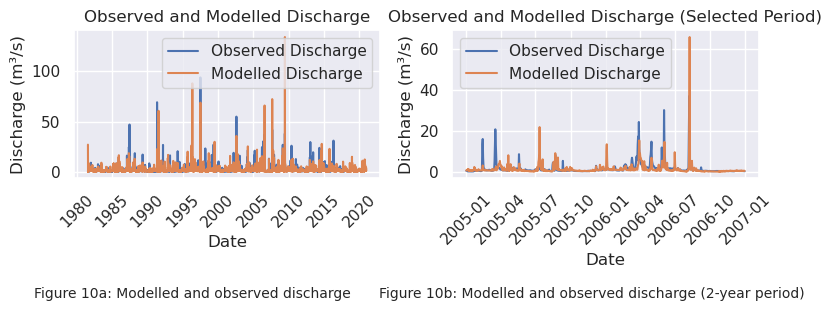

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

catchment_area = ds_forcing["area"].values

model_data = df['Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

discharge = []
for i in range(len(ds_forcing["Q"].values)):
    discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

x = ds_forcing["time"].values
y = discharge

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))  # 1 rij en 2 kolommen

# Plot voor de volledige periode
axs[0].plot(x, y, label='Observed Discharge')
axs[0].plot(df.index, model_data, label='Modelled Discharge')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Discharge (m³/s)')
axs[0].set_title('Observed and Modelled Discharge')
axs[0].legend()
# axs[0].text(0.5, -1, "Figure 10a: Modelled and observed discharge", 
#             ha="center", fontsize=12, transform=axs[0].transAxes)


start_date = "2005-01-01"
end_date = "2006-12-31"

time_series = pd.to_datetime(ds_forcing["time"].values)
mask = (time_series >= start_date) & (time_series <= end_date)

filtered_time = time_series[mask]
filtered_discharge = [discharge[i] for i in range(len(discharge)) if mask[i]]
filtered_model_data = df.loc[start_date:end_date, 'Modelled_discharge'] * catchment_area * 1000 / (24 * 60 * 60)

axs[1].plot(filtered_time, filtered_discharge, label='Observed Discharge')
axs[1].plot(filtered_model_data.index, filtered_model_data, label='Modelled Discharge')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Discharge (m³/s)')
axs[1].set_title('Observed and Modelled Discharge (Selected Period)')
axs[1].legend()
# axs[1].text(0.5, -1, "Figure 10b: Modelled and observed discharge (2-year period)", 
#             ha="center", fontsize=12, transform=axs[1].transAxes)


fig.text(0.25, -0.02, "Figure 10a: Modelled and observed discharge", ha="center", fontsize=10)
fig.text(0.75, -0.02, "Figure 10b: Modelled and observed discharge (2-year period)", ha="center", fontsize=10)

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()



Below, in figure 11, the distribution of the modelled discharge is plotted. The blue line is fitted through the modelled data, and is extrapolated to be able to find out the return period for the threshold value. It can be seen that  a discharge of 530 m3/s has a return period of 398 years. In Chapter 3, the observed data resulted in a return period of 641 years for a discharge of 530 m3/s. These two extrapolated return periods are not exactly the same. In Chapter 3, the influence of peaks in the data was considered as well. Removing the highest peaks resulted in a return period of 923 years. Removing peaks from the data increases the return period. Removing the lowest discharges decreases the return period. The model overestimates the amount of peaks in the data, resulting in a smaller return period. Overestimating peaks is safer than underestimating peaks, because it prevents underdesigning of flood protection infrastructure and improves the preparedness for floodings. Since it can not be expected from the model to perfectly predict the discarges, a return period of 398 years for a discharge of 530 m3/s is considered close enough to the return period of 641 years for the observed data. 

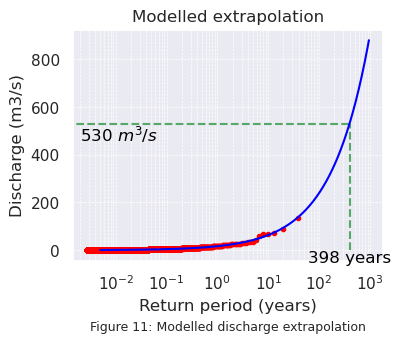

In [31]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
plt.figure(figsize=(4, 3))
# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend
#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365

def power_law(x, a, b):
    return a * x ** b
def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=10000)
    a_opt, b_opt = params

    x_fit = np.logspace(np.log(min(sorted_model_data) + 1e-1), np.log(max(return_periods_years_subset)/2), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt

x_fit, y_fit, a_opt, b_opt = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed', label="y=530 Line")
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed', label="Intersection to x-axis")
plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')
plt.text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.xscale('log')
plt.scatter(return_periods_years_model, sorted_model_data, color="red", label="Waarden", marker='.')
plt.plot(x_fit, y_fit, color='blue')
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')



plt.title('Modelled extrapolation')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.5, -0.3, "Figure 11: Modelled discharge extrapolation", 
         ha="center", fontsize=9, transform=plt.gca().transAxes);

# plt.savefig("/home/thirza/BEPproject/book/Grafieken/Scatter.png", dpi=300)

## Conclusion

It can be concluded that the best parameter combination for the catchment area of the Wien River is:\
Imax = 0.00\
Ce = 1.324\
Sumax = 100.048\
Beta = 3.894\
Pmax = 0.666\
Tlag = 0.043\
Kf = 1.005\
Ks = 1.94\
FM = 0.459

In the next chapter, the HBV model will be run using forcings generated by CMIP in combination with these parameters.